In [90]:
import funct
import importlib
funct = importlib.reload(funct)
import numpy as np
import pandas as pd
import os
import IPython
import netCDF4 as nc
import  xarray as xr


Read historical CCS data

incomplete data of June, 2021


In [139]:
freq = 3

# Get the current working directory
current_dir = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")[-5:]
    )
# Get the parent directory path
parent_dir = os.path.dirname(os.path.dirname(current_dir))
# Change the directory (optional)
os.chdir(parent_dir)
# Now, your current working directory is the parent folder.

rela_path_base = "Data\Persian_CCS_201901_202403\CCS_esmJSON_2024-03-08075032am_"
df_list = []
first_iter = True
for month in funct.iterate_months(2019, 1, 2024, 3):
    rela_path = rela_path_base + month + ".nc"
    df = funct.create_time_series_dataframe(freq, rela_path)
    if first_iter:
        df = df.replace(-99,np.nan)
        cols_after_drop = df.dropna(axis=1, how='any').columns
        first_iter = False
    df_dropped = df[[col for col in cols_after_drop]]
    df_list.append(df_dropped)
df_ccs = pd.concat(df_list)
# orginal shape of the Esmeraldas basin is of size 53*52
# New flat array of 1098 pixels, showing only the net pixels of this basin area 

Read and organize data from Esmeraldas station

In [121]:
# Get the current working directory
current_dir = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")[-5:]
    )
# Get the parent directory path
parent_dir = os.path.dirname(os.path.dirname(current_dir))
# Change the directory (optional)
os.chdir(parent_dir)
# Now, your current working directory is the parent folder.

from datetime import date, timedelta, datetime
from funct import format_number_with_zeros
import chardet
import re


# Define start and end dates (replace with your desired dates)
start_date = date(2023, 9, 6)  # Adjust year, month, day as needed
end_date = date(2024, 3, 8)  # Adjust year, month, day as needed

# Iterate through each day using a for loop and timedelta

df_list_esm = []
df_list_esm_err = []

# iterate to read every .csv file and convert them into transposed dataframe to align with the form of ccs data
for day in range((end_date - start_date).days + 1):
    current_date = start_date + timedelta(days=day)
    # Do something with the current_date here (e.g., print, process data)
    year = current_date.year
    month = format_number_with_zeros(current_date.month,2)
    day = format_number_with_zeros(current_date.day,2)
    csv_path = "Data\Esm_Station\yd" + str(year) + "\md" + str(year) + str(month) + "\\" + str(year) + str(month) + str(day) + "_dvd.csv"
    with open(csv_path, 'rb') as f:
        result = chardet.detect(f.read())
        encoding = result['encoding']
    df = pd.read_csv(csv_path, encoding= encoding, header = None ,skiprows=2)
    df = df[0].apply(lambda x: pd.Series(re.split(';', x)))
    df = df.T
    df.columns = df.iloc[0]
    head = df.iloc[0].values
    df = df.iloc[6:]
    df.drop(df.index[-1],inplace=True)
    df = df.set_index('N Sens', drop = True)
    times = [datetime.strptime(time, '%H.%M') for time in df.index]
    datetimes = [t.replace(year = year, month= current_date.month, day= current_date.day) for t in times]
    df.index = datetimes
    try:
        df.columns = ['hidro_level_m1','precip_acumu_sm','hidro_level_sm']
    except ValueError:
        df.columns = ['hidro_level_m1']
        # record the odd case with only data of a single sensor
        df_list_esm_err.append(df)
        print(current_date, head)

    df_list_esm.append(df)
# concat all the files
df_esm_all = pd.concat(df_list_esm)
# convert the data to be numeric
df_esm_all = df_esm_all.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == "object" else x)
# aggregate data with a unit frequency of 3 hours, nan values will be excluded from the calculation
df_esm_3h = df_esm_all.resample('3h').agg({'hidro_level_m1': 'mean', 'precip_acumu_sm': 'sum', 'hidro_level_sm':'mean'})

2023-10-01 ['N Sens' '78652']
2023-10-02 ['N Sens' '78652']
2023-10-03 ['N Sens' '78652']
2023-10-04 ['N Sens' '78652']
2023-10-05 ['N Sens' '78652']
2023-10-06 ['N Sens' '78652']
2023-10-12 ['N Sens' '78652']
2023-10-13 ['N Sens' '78652']
2023-10-14 ['N Sens' '78652']
2023-10-15 ['N Sens' '78652']
2023-10-16 ['N Sens' '78652']
2023-10-17 ['N Sens' '78652']
2023-10-18 ['N Sens' '78652']
2023-10-19 ['N Sens' '78652']
2023-10-20 ['N Sens' '78652']
2023-10-21 ['N Sens' '78652']
2023-10-22 ['N Sens' '78652']
2023-10-23 ['N Sens' '78652']
2023-10-24 ['N Sens' '78652']


C:\Users\liang.yang\AppData\Local\Temp\ipykernel_9620\97517442.py:62: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_esm_3h = df_esm_all.resample('3H').agg({'hidro_level_m1': 'mean', 'precip_acumu_sm': 'sum', 'hidro_level_sm':'mean'})


Merge the ccs data and Esmeradals data from CAE together and output to the local .csv file

In [129]:
merged_df = pd.merge(df_ccs, df_esm_3h, left_index=True, right_index=True, how='outer')
merged_df.shape
# shape of (time, 2759), where 2759 = 53*52 (# of pixels de Esm basin ) + 3 (# of sensors)
start = str(merged_df.index[0].date())
end  = str(merged_df.index[-1].date())
merged_df.to_csv(f'merged_{start}_{end}.csv', compression= None)


(14754, 1101)

# Drafts Below

In [128]:
diff = date(2024,3,8)-date(2019,1,1)
diff.days*8

15144

In [137]:
d = date(2021,6,10)-date(2021,1,1)
d.days

160

Heatmap

C:\Users\liang.yang\AppData\Local\Temp\ipykernel_9620\806779927.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.DataFrame({'timestamp': pd.to_datetime(timestamps)})


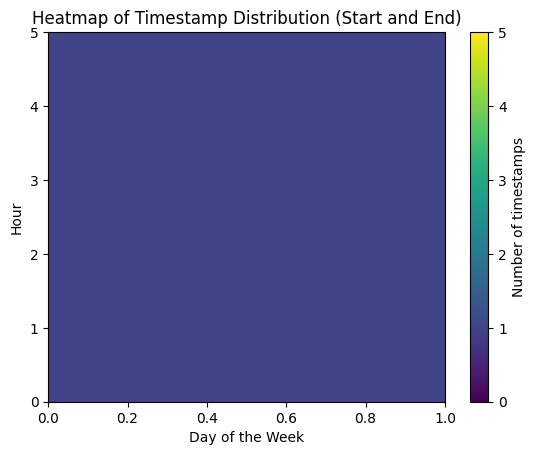

In [135]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample timestamps as a list of strings
timestamps = ["10:00:00", "11:30:00", "13:00:00", "15:15:00", "17:00:00"]

# Convert timestamps to datetime objects
df = pd.DataFrame({'timestamp': pd.to_datetime(timestamps)})

# Calculate day and hour for each timestamp
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour

# Create a heatmap using hour as rows and day as columns
pivot_table = df.pivot_table(index='hour', columns='day', values='timestamp', aggfunc='count')

# Configure the heatmap plot
plt.pcolor(pivot_table, vmin=0, vmax=len(timestamps))  # Set color range
plt.xlabel("Day of the Week")
plt.ylabel("Hour")
plt.title("Heatmap of Timestamp Distribution (Start and End)")
plt.colorbar(label="Number of timestamps")
plt.show()


In [ ]:
# Get the current working directory
current_dir = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")[-5:]
    )
# Get the parent directory path
parent_dir = os.path.dirname(os.path.dirname(current_dir))
# Change the directory (optional)
os.chdir(parent_dir)
# Now, your current working directory is the parent folder.

rela_path_base = "Data\Persian_CCS_201901_202403\CCS_esmJSON_2024-03-08075032am_"
rela_path = rela_path_base + '202106' + ".nc"
file_path = os.path.join(parent_dir,rela_path)
ds = nc.Dataset(rela_path)